<a href="https://colab.research.google.com/github/werixx1/MRI-Alzheimer-Stages-Detection-CNN/blob/main/notebooks/AlzheimerDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Wymagania:
## NA KOŃCU - RAPORTY
1. Należy przygotować sobie bazę danych do klasyfikacji zdjęć (binarną lub
wieloklasową) ✅
2. Wytrenować model na sieci ResNet50 od zera (bez transfer learningu) na CPU
- uzyskane wyniki (czas treningu oraz dokładność) będą stanowić base line
dla kolejnych wyników. ✅
3. W celu optymalizacji szybkości treningu zastosować:
- a. akcelerator GPU - przygotować raport porównawczy z czasem trenowania
bez i z GPU,
- b. transfer learning - przygotować raport porównawczy z transfer
learningiem i bez, interesuje nas tutaj dojście do pewnego poziomu
dokładności np. 80%.
4. W celu optymalizacji dokładności zastosować:
- a. normalizację - przygotować raport porównawczy z normalizacją danych i
bez.
- b. augumentację danych - przygotować raport porównawczy z
augumentacją i bez + informacją jakie przekształcenia zostały
przeprowadzone.
- c. dropout - przygotować raport porównawczy z zastosowaniem dropoutu i
bez.
- d. dokładanie danych - przygotować raport porównawczy z dołożeniem
nowej partii danych i bez.
- e. różne rozmiary wejściowe (np. 96x96, 160x160, 224x224) - przygotować
raport porównawczy dla każdego rozmiaru.
- f. różny rozmiar Batch size (np. 32, 64, 128) - przygotować raport
porównawczy dla każdego rozmiaru.
- g. różne struktury sieci (np. VGG16, ResNet101, InceptionV3, MobileNet) -
przygotować raport porównawczy dla każdej sieci (min. 4).

## 0. Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import zipfile
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

## 1. Loading dataset + quick exploration

In [2]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset
with zipfile.ZipFile("augmented-alzheimer-mri-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("alzheimer_dataset")

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
 87% 329M/380M [00:00<00:00, 774MB/s]
100% 380M/380M [00:00<00:00, 650MB/s]


In [8]:
image_count = len(list(glob.glob('alzheimer_dataset/AugmentedAlzheimerDataset/**/*.jpg')))
print(f'{image_count} examples of MRI brain photos in augmented dataset')

33984 examples of MRI brain photos in augmented dataset


In [9]:
# using only augmented data
base_dir = 'alzheimer_dataset/AugmentedAlzheimerDataset'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, fname))
            labels.append(label)
alzheimer_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print('Labels and number of photos')
print('-'*10)
print(alzheimer_df["labels"].value_counts())

Labels and number of photos
----------
labels
NonDemented         9600
MildDemented        8960
VeryMildDemented    8960
ModerateDemented    6464
Name: count, dtype: int64


In [10]:
alzheimer_df.shape

(33984, 2)

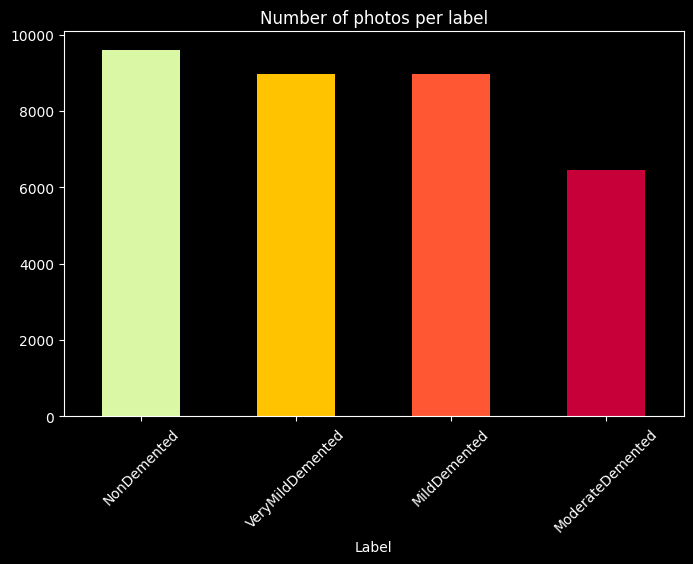

In [10]:
import matplotlib.pyplot as plt
counts = alzheimer_df['labels'].value_counts()

colors = ['#DAF7A6', '#FFC300', '#FF5733', '#C70039']
counts.plot(kind='bar', color=colors, figsize=(8,5))

plt.title("Number of photos per label")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.style.use('dark_background')
plt.show()

Example of moderate demented brain VS non demented brain from dataset


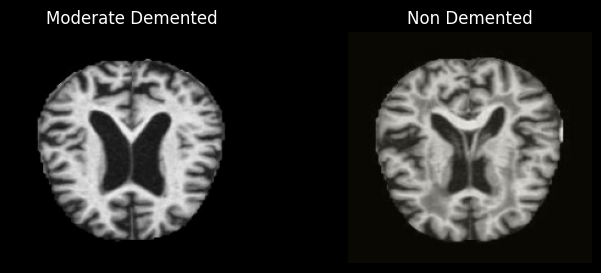

In [11]:
moderate_demented_example = list(glob.glob('alzheimer_dataset/AugmentedAlzheimerDataset/ModerateDemented/*'))
non_demented_example = list(glob.glob('alzheimer_dataset/AugmentedAlzheimerDataset/NonDemented/*'))
print('Example of moderate demented brain VS non demented brain from dataset')
img_demented = PIL.Image.open(str(moderate_demented_example[2]))
img_non_demented = PIL.Image.open(str(non_demented_example[2]))
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].imshow(img_demented)
axs[0].set_title("Moderate Demented")
axs[0].axis('off')

axs[1].imshow(img_non_demented)
axs[1].set_title("Non Demented")
axs[1].axis('off')

plt.style.use('dark_background')
plt.show()

## 2. ResNet50 without transfer learning on CPU

In [11]:
batch_size = 32
class_count = 4
img_height = 64
img_width = 64

In [12]:
small_df = alzheimer_df.sample(n=5000, random_state=42) # training on 5000 samples because im not waiting 3 days
train_val_set, test_set = train_test_split(
    small_df,
    test_size=0.2,
    stratify=small_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

print(f"Number of training samples: {len(train_set)}")
print(f"Number of validation samples: {len(val_set)}")
print(f"Number of testing samples: {len(test_set)}")

Number of training samples: 3200
Number of validation samples: 800
Number of testing samples: 1000


In [13]:
img_gen = ImageDataGenerator() # makes it possible to load images in batches rather than all at once
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width), # changing size for faster training
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3200 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.


In [14]:
test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1000 validated image filenames belonging to 4 classes.


In [15]:
input_shape = (img_height, img_width, 3) # image input size
resnet50_base_model = ResNet50(include_top=False,
                         weights=None, # no transfer learning
                         classes=class_count,
                         input_shape=input_shape)

x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x) # what the siet
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [17]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 589s 5s/step - accuracy: 0.2990 - loss: 2.6999 - val_accuracy: 0.2850 - val_loss: 24.7026
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 566s 6s/step - accuracy: 0.4380 - loss: 1.3803 - val_accuracy: 0.5088 - val_loss: 1.1203
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 561s 6s/step - accuracy: 0.5526 - loss: 1.2333 - val_accuracy: 0.3212 - val_loss: 69.7189
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 584s 6s/step - accuracy: 0.5202 - loss: 1.1514 - val_accuracy: 0.3013 - val_loss: 12.8979
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 582s 6s/step - accuracy: 0.5718 - loss: 1.1555 - val_accuracy: 0.2725 - val_loss: 1262.3832
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 578s 6s/step - accuracy: 0.5778 - loss: 1.0419 - val_accuracy: 0.3400 - val_loss: 12.4149
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 571s 6s/step - accuracy: 0.6200 - loss: 0.9648 - val_accuracy: 0.4850 - val_loss: 1.1891
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 564s 6s/step - accuracy: 0.6558 - loss: 0.8991 - val_accuracy

In [29]:
resnet50_base_training_time = training_end_time - training_start_time
test_loss, resnet50_base_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_base_accuracy:.4f}') # o.....
print(f'Training took {resnet50_base_training_time / 60:.2f} minutes')

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 517ms/step - accuracy: 0.2563 - loss: 4.5173
--------------------------------------------------
Test accuracy: 0.2810
Training took 97.29 minutes


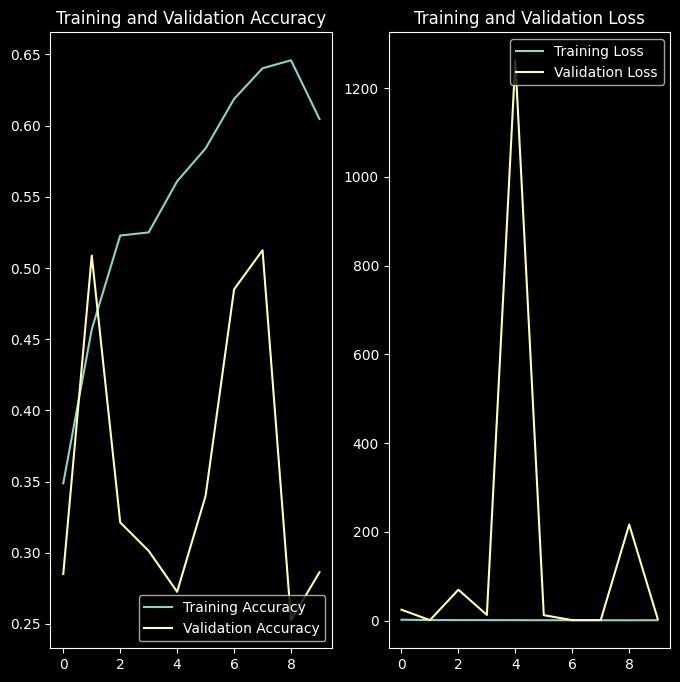

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 3a. ResNet50 without transfer learning on GPU

In [16]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 103ms/step - accuracy: 0.3046 - loss: 2.1345 - val_accuracy: 0.2625 - val_loss: 2.2177
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.5017 - loss: 1.1499 - val_accuracy: 0.3438 - val_loss: 1.5374
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.6178 - loss: 0.9164 - val_accuracy: 0.4087 - val_loss: 1.5792
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6347 - loss: 0.8870 - val_accuracy: 0.3113 - val_loss: 3.4616
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.6745 - loss: 0.7901 - val_accuracy: 0.4412 - val_loss: 1.8437
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7240 - loss: 0.6685 - val_accuracy: 0.4900 - val_loss: 1.6670
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.7423 - loss: 0.6295 - val_accuracy: 0.5625 - val_loss: 2.0464
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7648 - loss: 0.5832 - val_accuracy: 0.

In [33]:
resnet50_gpu_training_time = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50_gpu_training_time / 60:.2f} minutes')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.6858 - loss: 0.7192
--------------------------------------------------
Test accuracy: 0.6660
Training took 3.79 minutes


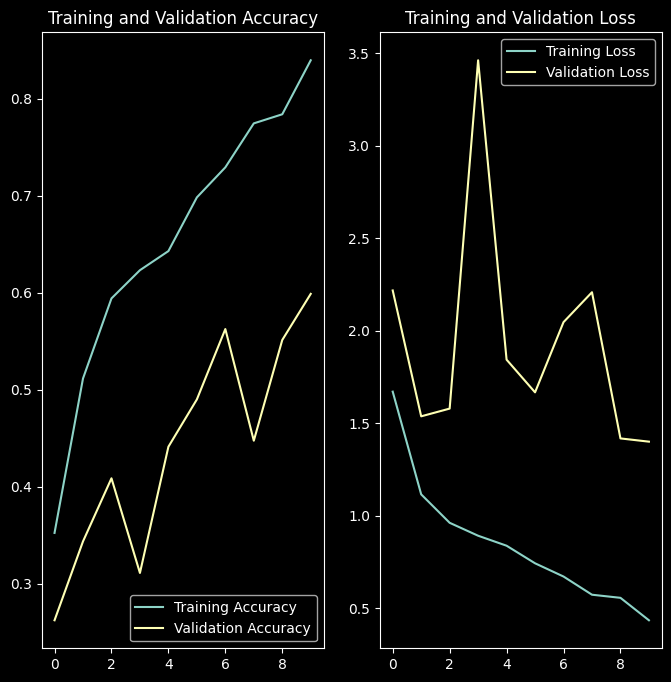

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 3a. ResNet50 with transfer learning on GPU

In [42]:
medium_df = alzheimer_df.sample(n=10000, random_state=42) # more samples for better accuracy (i hope)
train_val_set, test_set = train_test_split(
    medium_df,
    test_size=0.2,
    stratify=medium_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6400 validated image filenames belonging to 4 classes.
Found 1600 validated image filenames belonging to 4 classes.
Found 2000 validated image filenames belonging to 4 classes.


In [ ]:
input_shape = (img_height, img_width, 3)
resnet50_transferlearning_model = ResNet50(include_top=False,
                         weights='imagenet', # transfer learning
                         classes=class_count,
                         input_shape=input_shape)
resnet50_transferlearning_model.trainable = False

x = resnet50_transferlearning_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_transferlearning_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [48]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=22) # actually giving model time to learn
training_end_time = time.time()

Epoch 1/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.7521 - loss: 0.6023 - val_accuracy: 0.6969 - val_loss: 0.6877
Epoch 2/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - accuracy: 0.7436 - loss: 0.5950 - val_accuracy: 0.6956 - val_loss: 0.6952
Epoch 3/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7640 - loss: 0.5817 - val_accuracy: 0.7088 - val_loss: 0.6753
Epoch 4/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.7643 - loss: 0.5848 - val_accuracy: 0.7181 - val_loss: 0.6618
Epoch 5/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7780 - loss: 0.5495 - val_accuracy: 0.7219 - val_loss: 0.6776
Epoch 6/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.7700 - loss: 0.5623 - val_accuracy: 0.7081 - val_loss: 0.6574
Epoch 7/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.7807 - loss: 0.5388 - val_accuracy: 0.7119 - val_loss: 0.6555
Epoch 8/22
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.7777 - loss: 0

In [49]:
resnet50_tl_training_time = training_end_time - training_start_time
test_loss, resnet50_tl_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_tl_accuracy:.4f}')
print(f'Training took {resnet50_tl_training_time / 60:.2f} minutes')

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.7336 - loss: 0.6045
--------------------------------------------------
Test accuracy: 0.7285
Training took 9.10 minutes


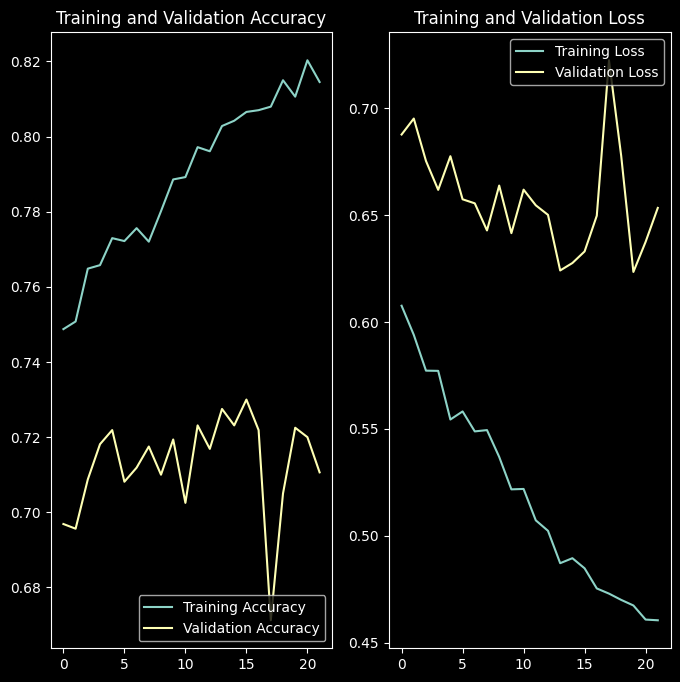

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(22)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()